# Decision Trees and Random Forests

Shaurya Jauhari (Email: shauryajauhari@gzhmu.edu.cn)

Welcome to the second workshop in the series of **Machine Learning Fundamentals**. In this session, we shall explore the theory of **Decision Trees** and scale it to the broader concept of **Random Forests**. Decision trees epitomize the divide and conquer strategy to accomplish classification tasks (although they could also be implemented for regression chores as well)(Quinlan 1986, Rokach 2005). From the previous session on **Logistic Regression**, you may recall that if the response variable is catergorical in nature (factors in R), we aim classification, or else, if the response variable is continuous, it denotes regression. Classification and regression methodologies are both categorized under supervised machine learning. The theme of machine learning was realized in 1950s and since then, coupled with the data deluge and upheaval in computational prowess, has exhibited stronghold in data analysis domain (See figure below).

![Machine Learning Genesis](./ML_Genesis.png)

In order to appreciate the concept of random forests, it is incumbent to learn about decision trees. A decision tree is the unit of random forest. 

There is also an added understanding about dimensionality reduction in decision trees (and random forests as well). Recollecting the same concept in logistic regression, the idea was to penalize "non-performing" features by reducing their coefficients close to(alpha=0:Ridge) or equal to zero(alpha=1:Lasso)(there is also a provision for replicating the objective of train-test data partitioning, i.e. cross-validation). In decision trees, entropy, information gain, variance-bias, chi-square coefficients, gini-index, etc. parameters are optionally calculated to ascertain the best attribute to split/ partition the tree. It is crucial to engender the tree a definitive structure, else the curse of biasness in decision trees for continuous and nominal data comes to play.   

Random forests enlighten on the dogma of democracy, i.e. *majority wins*. Decision Trees are rudimentary classification algorithms that, at a low-level, are synonymous to *if-then* conditional statements in programming languages. They follow the strategy of iterative recursion, and intuitively the leaf nodes hold the final verdict. The highest aggregate from all leaf nodes (terminals) is graded as the output of that decision tree.  

In this module, we shall delve into creation of basic decision trees to have an understanding of it. For the purpose, we shall load the package **party** and make use of the function **ctree()** to calculate and analyze decision trees. Furthermore, we shall require the packages **rpart**, **party**, **randomForest** as well. Let's load them up.

# Decision Trees 

## Package Installation and Loading

In [20]:
install.packages("party", dependencies = TRUE, repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/")
install.packages("rpart", dependencies = TRUE, repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/")
install.packages("rpart.plot", dependencies = TRUE, repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/")
library(party)
library(rpart)
library(rpart.plot)


The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpQHF7Nw/downloaded_packages

The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpQHF7Nw/downloaded_packages

The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpQHF7Nw/downloaded_packages

The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpQHF7Nw/downloaded_packages


Let us now, pick up a dataset. The dataset pertains to the soft computation of the **enhancer prediction** module in bioinformatics. We certainly take into cognizance the biological implications about enhancer regions (See figure below).   
Certain known classes of proteins/ cis-regulatory elements called Transcription Factors (TFs) and Transcription Co-Activators (TCoAs) are programmed to bind to regions in the genome called *Enhancers*, that remotely orchestrate the phenomena of gene regulation. They are at a distal location to the *Promoters*, regions associated with genes and respective Transcription Start Sites (TSS). On stimulus from TFs, the enhancer and promoter sequences reciprocate and actuate the transcription machinery.

![Enhancer Prediction Basis](./WorkFlow_Illustration.jpg)

## Dataset handling

For use in this session, we have chosen a compound dataset from the studies as follows; for **non-enhancer** data, we referenced "Chromatin accessibility assay of IMR90 Cell Line; DS11759", sample dataset deposited to GEO labeled GSM468792. (P.S. Although these are not, but if a  dataset is originally available as a WIG file, firstly, it is converted to BED and is then subsequently cleaned for  use(See Notes: 3).
To add to the positive class data, we consider regions that are **enhancers**. Under this category, we include regions from ChIP-Seq study from GSM929090, available as a BED file. These are p300 binding sites from the IMR90 cell lines. Also, in interest of this exercise, we shall consider marginally upper proportion of non-enhancers than enhancer regions; enhancer sites are lower in number in comparison to the promoter sites (Rajagopal 2013).

![Dataset Profile](./Dataset_Profile.jpg)

Prior to deploying these datasets, they were screened for overlapping regions, i.e. conditions where start and end indexes of one range intersected with the same indexes of the following range. To curtail those regions, an overall normalization was performed using **bedtools** on the command prompt.

**sort -k1,1 -k2,2n GSM929090.bed | mergeBed > GSM929090_uniq.bed**   
**sort -k1,1 -k2,2n GSM468792.bed | mergeBed > GSM468792_uniq.bed**

In [21]:
mydata_enhancers <- read.csv("./GSM929090_uniq.bed", sep = '\t', header = FALSE)
mydata_nonenhancers <- read.csv("./GSM468792_uniq.bed", sep = '\t', header = FALSE)

We choose to incorporate only those peaks with occurence of 1 and above. Additionally, a column for "Class" has been added that uniformly holds the value "Enhancer" as all the peaks correspond to p300 bindings in the genome. Finally, we have also pruned the dataset for columns on peak ids and frequencies as they are beyond the scope of our analysis.

In [22]:
mydata_enhancers <- mydata_enhancers[,c(1,2,3)]
mydata_enhancers$Class <- "Enhancer"
colnames(mydata_enhancers) <- c("Chrom", "Start", "End", "Class")

In [23]:
set.seed(1)
nonenhancer_indexes <- sample(1:nrow(mydata_nonenhancers),(3/2*nrow(mydata_enhancers))) 
mydata_nonenhancers <- mydata_nonenhancers[nonenhancer_indexes,]

Again for the nonenhancer data, we shall be following the same protocol.

In [24]:
mydata_nonenhancers <- mydata_nonenhancers[,c(1,2,3)]
mydata_nonenhancers$Class <- "Non-Enhancer"
colnames(mydata_nonenhancers) <- c("Chrom", "Start", "End", "Class")

We have hit a roadbloack here! In order to execute for decision trees, given the dataset, we shall always have a node
that is having two attributes minimum. Since fields "Chrom", "Start", and "End" are intimately related, we will need 
"Chrom" as default attribute, alongwith "Start" and "End" both. There are two ways to solve this problem. First is 
to have a tree with two attributes at each node. Second way could help by, (i) having the file in sorted order by 
chromosome names, (ii) and then setting up a new column indicating **cumulative** "Start" and "End" extremities. 

Let us try the second way out.
It is better to confirm if we have the data in sorted order by chromosomes.

In [25]:
mydata_enhancers_sorted_chrom_names <- mydata_enhancers[with(mydata_enhancers, order(Chrom, Start)), ]
mydata_nonenhancers_sorted_chrom_names <- mydata_nonenhancers[with(mydata_nonenhancers, order(Chrom, Start)), ]

Cool! Eventually, we converge these dataframes into one and *voila* you have a base version of the dataset to work upon. Let's say we name it *my_consolidated_dataset*. 

In [26]:
my_consolidated_dataset <- rbind(mydata_enhancers_sorted_chrom_names, mydata_nonenhancers_sorted_chrom_names)
my_consolidated_dataset <- my_consolidated_dataset[with(my_consolidated_dataset, order(Chrom, Start)), ]

In addition we're also not willing to process random chromosomal entries that might've crept in.

In [27]:
chromosomes <- c("chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14",
                  "chr15", "chr16", "chr17", "chr18", "chr19", "chr20","chr21", "chr22", "chrX", "chrY")
my_consolidated_dataset<- as.data.frame(my_consolidated_dataset[my_consolidated_dataset$Chrom %in% chromosomes, ])
my_consolidated_dataset

,Chrom,Start,End,Class
,<fct>,<int>,<int>,<chr>
1,chr1,7325,7369,Enhancer
11000008,chr1,9969,10008,Non-Enhancer
21000000,chr1,10152,10194,Non-Enhancer
31000000,chr1,10232,10292,Non-Enhancer
41000000,chr1,10316,10351,Non-Enhancer
51000000,chr1,10444,10471,Non-Enhancer
61000000,chr1,10508,10566,Non-Enhancer
7619650,chr1,10778,10802,Non-Enhancer
8100008,chr1,11240,11273,Non-Enhancer


You would've noticed one thing. The class variable is a "character". We would like it to be factor variable as we're dealing with the "classical" classification problem. Note that this manipulation can also be carried out at the time of defining the *Class* variable too.

In the interest of problem illustration and considering the limitations of the processing and memory, we'll take liberty to highlight subset for *chr1* only and within that 10,000 examples.

In [32]:
set.seed(2)
my_consolidated_dataset$Class <- factor(my_consolidated_dataset$Class)
chr1_data<- my_consolidated_dataset[my_consolidated_dataset$Chrom == "chr1", ]
chr1_data_sample_indexes <- sample(1:nrow(chr1_data), 10000) 
chr1_data_sample <- chr1_data[chr1_data_sample_indexes,]

### Deploying Tree Models
#### 'party' package

Let us now partition the data into test and validation cases. We shall be assuming 80% of the data for training and 20% for testing tasks.

In [40]:
set.seed(3)
data_partition <- sample(2, nrow(chr1_data_sample), replace = TRUE, prob = c(0.8,0.2))
train <- chr1_data_sample[data_partition==1,]
test <- chr1_data_sample[data_partition==2,]

#### Exercise
- Try data partitioning with a 70:30 split for training and testing examples. See if it makes any difference in the classification ahead.

In [41]:
cat("We have",nrow(train),"trainig examples and",nrow(test),"for testing.")

We have 8016 trainig examples and 1984 for testing.

In [36]:
chr1_tree <- ctree(Class~Start+End, data= train)
print(chr1_tree)


	 Conditional inference tree with 4 terminal nodes

Response:  Class 
Inputs:  Start, End 
Number of observations:  8016 

1) Start <= 64272514; criterion = 1, statistic = 15.171
  2)*  weights = 2611 
1) Start > 64272514
  3) End <= 245759082; criterion = 1, statistic = 14.087
    4) End <= 109015842; criterion = 1, statistic = 22.457
      5)*  weights = 1360 
    4) End > 109015842
      6)*  weights = 3968 
  3) End > 245759082
    7)*  weights = 77 


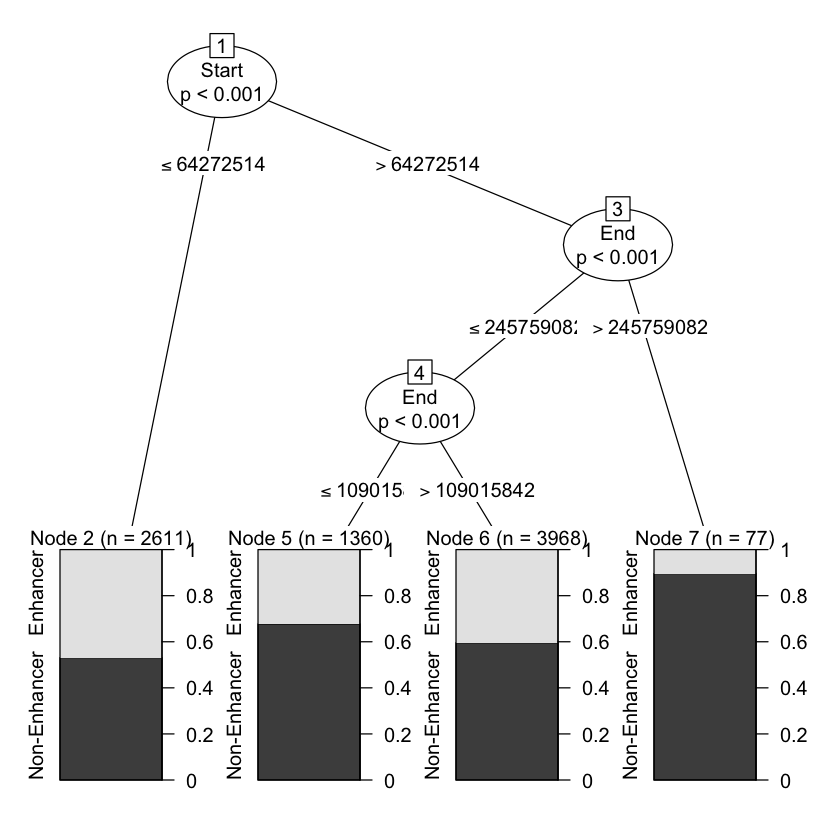

In [37]:
plot(chr1_tree)

#### Exercise
- Addtionally, the function ctree() offers flexibility in terms of defining parameters for classification via ctree_control() function. Look for attributes *mincriterion* and *minsplit*. The former denotes the confidence level (i.e. 1- probability value), while the latter signifies the minimum number of samples required for splitting a tree branch into two. The default values are 0.95 and 20 respectively. See if any alteration makes a difference.
- They can be accessed via *controls*, i.e. ctree(formula,data,controls=ctree_control(mincriterion= , minsplit= ).
- You may explore other attributes too.

In [135]:
tree_pred <- predict(chr1_tree,test)
head(tree_pred)

[1] Non-Enhancer Non-Enhancer Non-Enhancer Non-Enhancer Non-Enhancer
[6] Non-Enhancer
Levels: Enhancer Non-Enhancer

In [136]:
tree_pred_prob <- predict(chr1_tree,test, type="prob")
head(tree_pred_prob)

[[1]]
[1] 0.3227941 0.6772059

[[2]]
[1] 0.4687859 0.5312141

[[3]]
[1] 0.4687859 0.5312141

[[4]]
[1] 0.4042339 0.5957661

[[5]]
[1] 0.4042339 0.5957661

[[6]]
[1] 0.4042339 0.5957661

#### Misclassification Error

In [48]:
tab <- table(tree_pred, test$Class)
print(tab)

              
tree_pred      Enhancer Non-Enhancer
  Enhancer            0            0
  Non-Enhancer      806         1178


In [56]:
accur <- 1 - sum(diag(tab))/sum(tab)
cat("The accuracy of the model is",accur*100,"%")
#print("\n")
ifelse(accur>90, print("Not bad."), print("Poor."))

The accuracy of the model is 40.625 %[1] "\n"
[1] "Poor."


[1] "Poor."

#### Exercise
- What do you think the misclassification error will be like if the table is drawn for *train* data?

#### 'rpart' package

In [57]:
chr1_tree1 <- rpart(Class~Start+End, data= train)
print(chr1_tree1)

n= 8016 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 8016 3275 Non-Enhancer (0.4085579 0.5914421) *


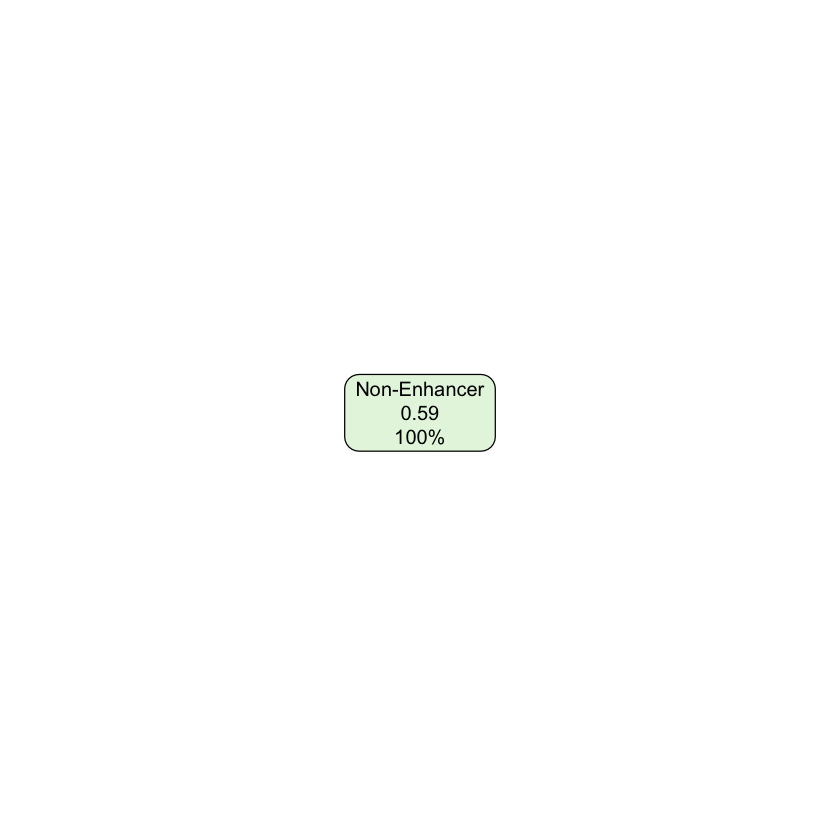

In [58]:
rpart.plot(chr1_tree1)

In [137]:
tree_pred1 <- predict(chr1_tree1,test)
head(tree_pred1)

Enhancer,Non-Enhancer
0.4085579,0.5914421
0.4085579,0.5914421
0.4085579,0.5914421
0.4085579,0.5914421
0.4085579,0.5914421
0.4085579,0.5914421


There is a complete contrast between the two trees drawn from *ctree()* and *rpart()* functions. The *ctree* uses a significance test procedure in order to select variables instead of selecting the variable that maximizes an information measure (e.g. Gini coefficient). Basically the methodology of both approaches is different; *rpart* is a CART algorithm, while *party* is a CHAID algorithm. (http://www.bzst.com/2006/10/classification-trees-cart-vs-chaid.html).

Next, we move to the more fuller concept, of Random Forests.

# Random Forests

Decision trees are accomodated inside Random Forests. This ensemble brings about variety in data classification and hence more robustness. This notion also helps in avoidance of overfitting. Random forests can deal with large number of features and selects them for constructing trees on the basis of importance. As we will see, they are easy to implement and have two free parameters to tune- (i) *ntree* signifying the number of trees (where default value is 500), and (ii) *mtry* denoting variables randomly selected for each split (default here sq(p) when classification is sought, and (p/3) when regression; p is the total number of features in the dataset) 

## Package Installation and Loading

In [63]:
install.packages("randomForest", dependencies = TRUE, repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/")
install.packages("caret", dependencies = TRUE, repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/")
library(randomForest)
library(caret)


The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpQHF7Nw/downloaded_packages


also installing the dependencies ‘profileModel’, ‘labelled’, ‘gower’, ‘RcppRoll’, ‘timeDate’, ‘brglm’, ‘qvcalc’, ‘combinat’, ‘questionr’, ‘ISwR’, ‘ModelMetrics’, ‘recipes’, ‘BradleyTerry2’, ‘fastICA’, ‘gam’, ‘kernlab’, ‘klaR’, ‘ellipse’, ‘mda’, ‘MLmetrics’, ‘pls’, ‘pROC’, ‘proxy’, ‘RANN’, ‘spls’, ‘subselect’, ‘pamr’, ‘superpc’, ‘Cubist’




The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpQHF7Nw/downloaded_packages


Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



There are basically three steps involved in construction of a Random Forest:
    1. Draw *ntree* bootstrap samples.
    2. For each bootstrap sample, grow a un-pruned tree by choosing best split based on a random sample of *mtry* predictors at each node.
    3. Predict new daat using majority votes for classification, and average for regression based on *ntree* trees.

In [73]:
# Execute random forest algorithm
rf1 <- randomForest(formula= Class~.,data= train)
print(rf1)


Call:
 randomForest(formula = Class ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 40.86%
Confusion matrix:
             Enhancer Non-Enhancer class.error
Enhancer            0         3275           1
Non-Enhancer        0         4741           0


In [93]:
# Prediction and Confusion Matrix
p1<- predict(rf1,train)
confusionMatrix(p1,train$Class)

Confusion Matrix and Statistics

              Reference
Prediction     Enhancer Non-Enhancer
  Enhancer            0            0
  Non-Enhancer     3275         4741
                                          
               Accuracy : 0.5914          
                 95% CI : (0.5806, 0.6022)
    No Information Rate : 0.5914          
    P-Value [Acc > NIR] : 0.5048          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.5914          
             Prevalence : 0.4086          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positiv

In [94]:
p2<- predict(rf1,test)
confusionMatrix(p2,test$Class)

Confusion Matrix and Statistics

              Reference
Prediction     Enhancer Non-Enhancer
  Enhancer            0            0
  Non-Enhancer      806         1178
                                          
               Accuracy : 0.5938          
                 95% CI : (0.5718, 0.6155)
    No Information Rate : 0.5938          
    P-Value [Acc > NIR] : 0.5097          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.5938          
             Prevalence : 0.4062          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positiv

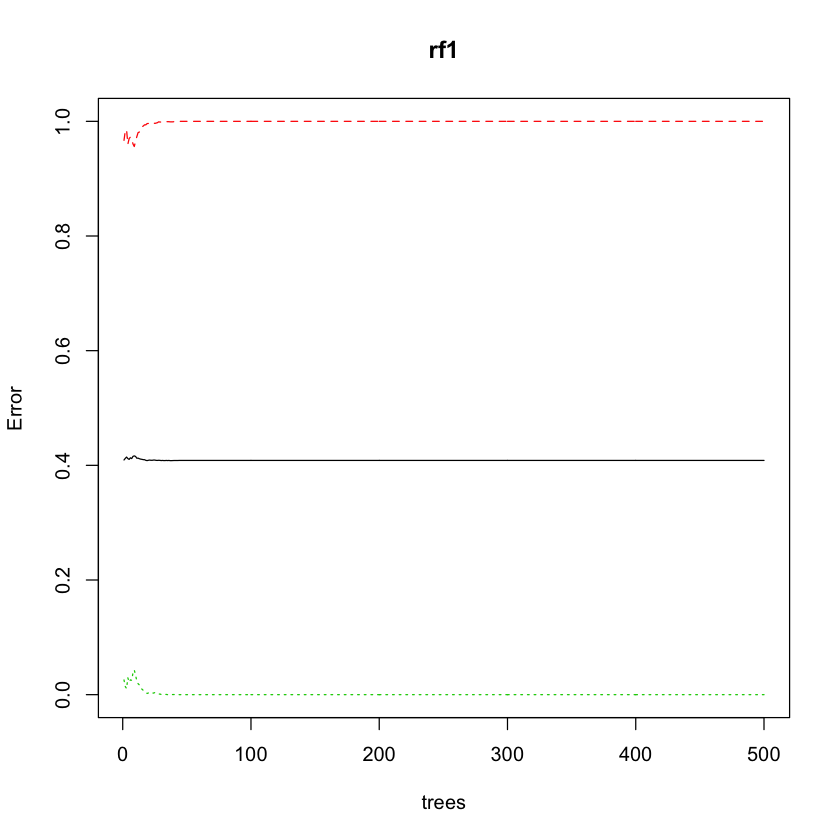

In [76]:
# Error rate of the Random Forest
plot(rf1)

The above plot shows that the error rate stablises after ~10 trees and any number of trees beyond doesn't bring any betterment to the error. In view of the same, we shall tune the paramaters of our forest to reduce the number of trees from 500 (default) to 10. Let us observe the change in results. This step helps ascertain an optimal value for *ntree*. 

mtry = 1  OOB error = 41.02% 
Searching left ...
Searching right ...
mtry = 2 	OOB error = 45.12% 
-0.100021 0.005 


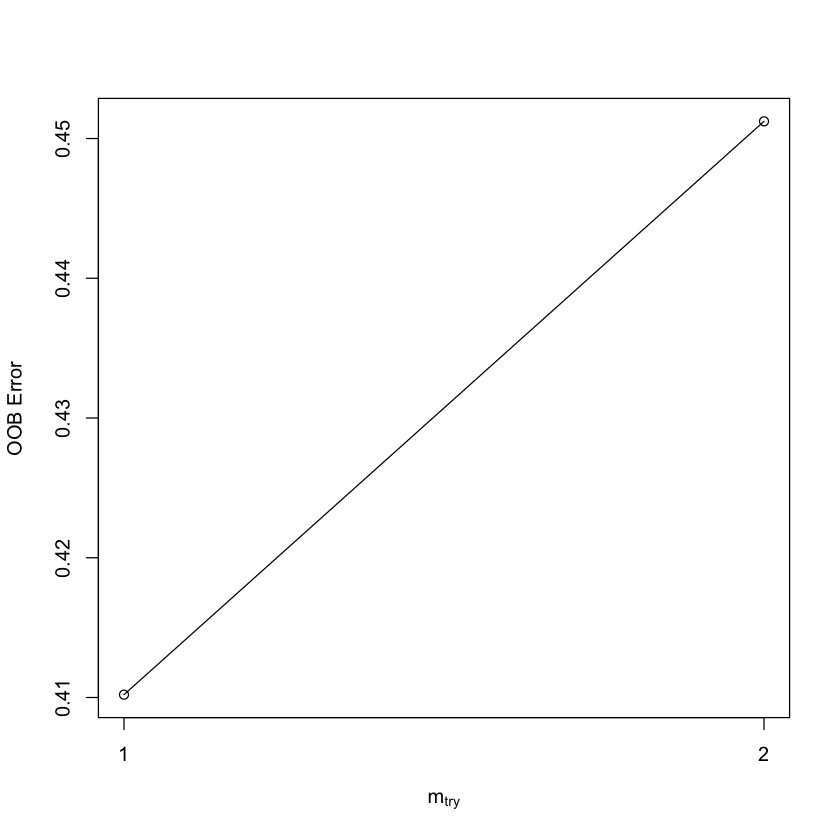

In [115]:
# Tuning mtry

t <- tuneRF(train[,-4], train[,4],
            stepFactor =2,
            plot = TRUE,
            ntreeTry = 10,
            trace = TRUE,
            improve = 0.005)               

We observe that OOB error stablises on assuming the random sample size of 1. This is the optimal value for *mtry* parameter. With the modified values of *mtry* and *ntee*, let us attempt our new Random Forest model. It will hopefully be an improved one.

In [116]:
rf2 <- randomForest(Class~.,
                    data = train,
                    ntree=10,
                    mtry=1,
                    importance= TRUE,
                    proximity = TRUE)
print(rf2)     


Call:
 randomForest(formula = Class ~ ., data = train, ntree = 10, mtry = 1,      importance = TRUE, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 10
No. of variables tried at each split: 1

        OOB estimate of  error rate: 40.71%
Confusion matrix:
             Enhancer Non-Enhancer class.error
Enhancer           39         3189 0.987918216
Non-Enhancer       37         4660 0.007877369


In [117]:
rf2 <- randomForest(Class~.,
                    data = test,
                    ntree=10,
                    mtry=1,
                    importance= TRUE,
                    proximity = TRUE)
print(rf2)  


Call:
 randomForest(formula = Class ~ ., data = test, ntree = 10, mtry = 1,      importance = TRUE, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 10
No. of variables tried at each split: 1

        OOB estimate of  error rate: 40.84%
Confusion matrix:
             Enhancer Non-Enhancer class.error
Enhancer           41          758  0.94868586
Non-Enhancer       45         1122  0.03856041


In [118]:
p3 <- predict(rf2, test)
confusionMatrix(p3,test$Class)

Confusion Matrix and Statistics

              Reference
Prediction     Enhancer Non-Enhancer
  Enhancer            8            1
  Non-Enhancer      798         1177
                                         
               Accuracy : 0.5973         
                 95% CI : (0.5753, 0.619)
    No Information Rate : 0.5938         
    P-Value [Acc > NIR] : 0.3837         
                                         
                  Kappa : 0.0108         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.009926       
            Specificity : 0.999151       
         Pos Pred Value : 0.888889       
         Neg Pred Value : 0.595949       
             Prevalence : 0.406250       
         Detection Rate : 0.004032       
   Detection Prevalence : 0.004536       
      Balanced Accuracy : 0.504538       
                                         
       'Positive' Class : Enhancer

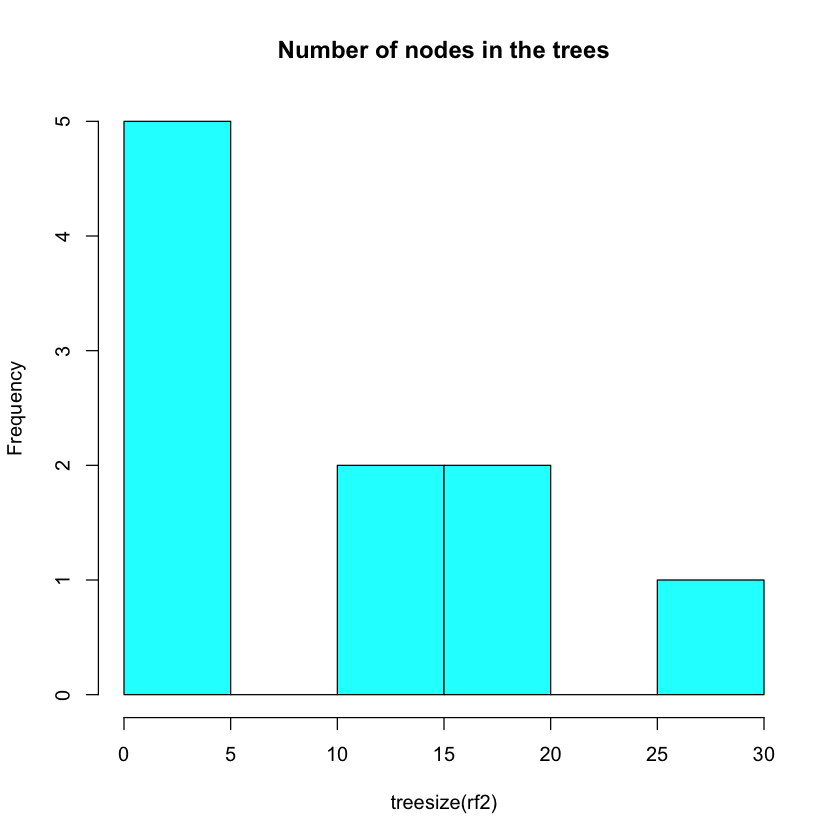

In [119]:
# Number of nodes for the trees
hist(treesize(rf2), col = "cyan", main = "Number of nodes in the trees")

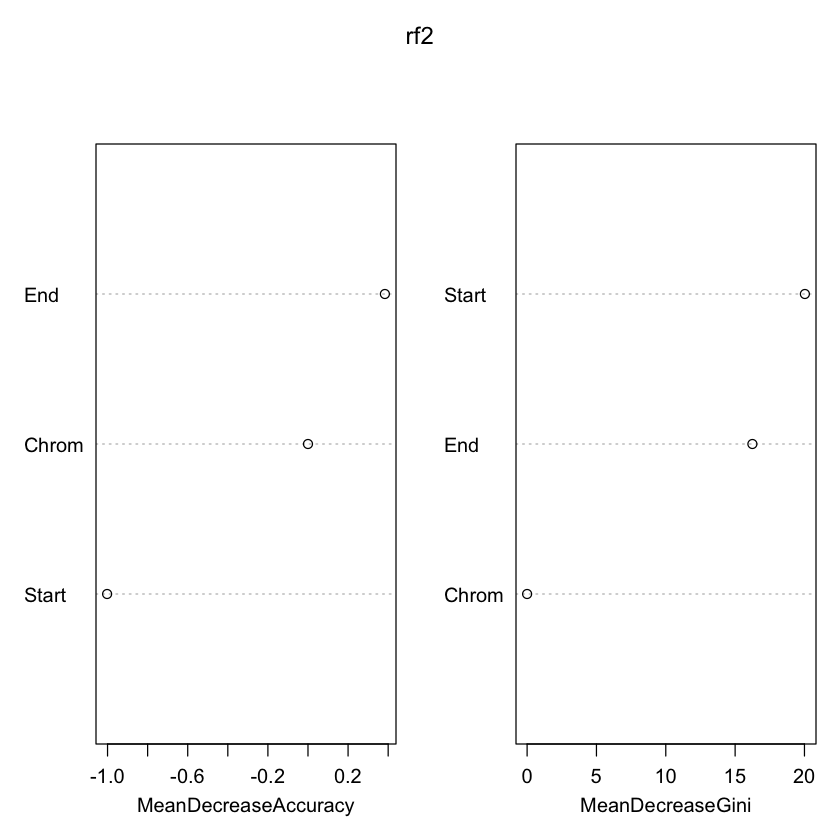

In [122]:
# Variable Importance

varImpPlot(rf2)

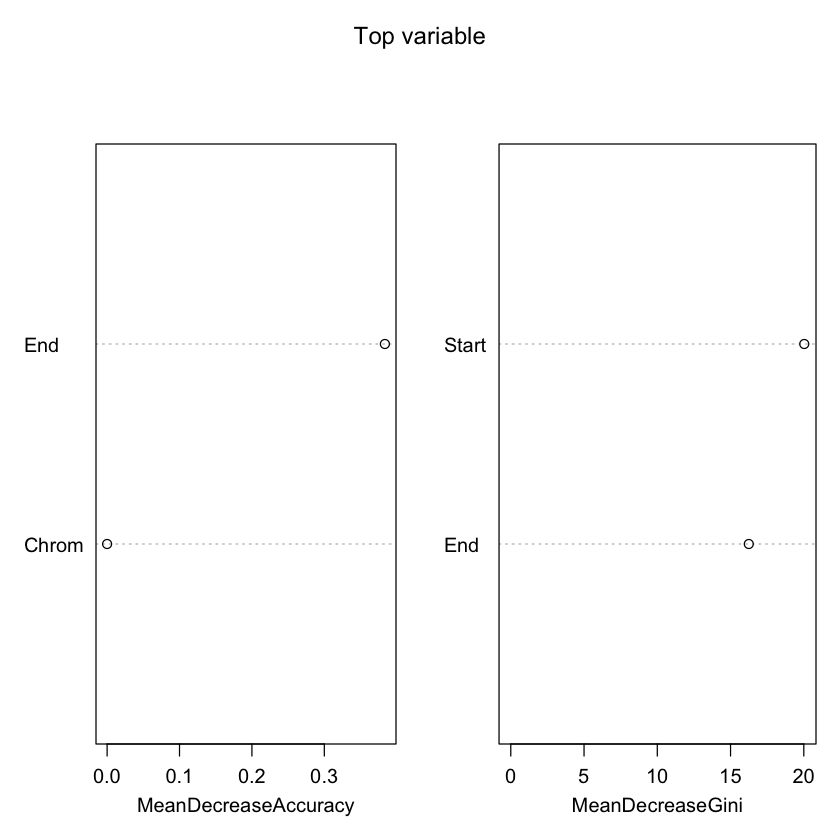

In [123]:
varImpPlot(rf2, sort = TRUE, n.var = 2, main = "Top variable")

In [125]:
importance(rf2)

,Enhancer,Non-Enhancer,MeanDecreaseAccuracy,MeanDecreaseGini
Chrom,0.0000000,0.0000000,0.0000000,0.00000
Start,-0.9063434,-0.3224052,-1.0021607,20.03105
End,0.7383435,0.1739666,0.3836733,16.24543


In [126]:
varUsed(rf2)

[1]  0 48 46

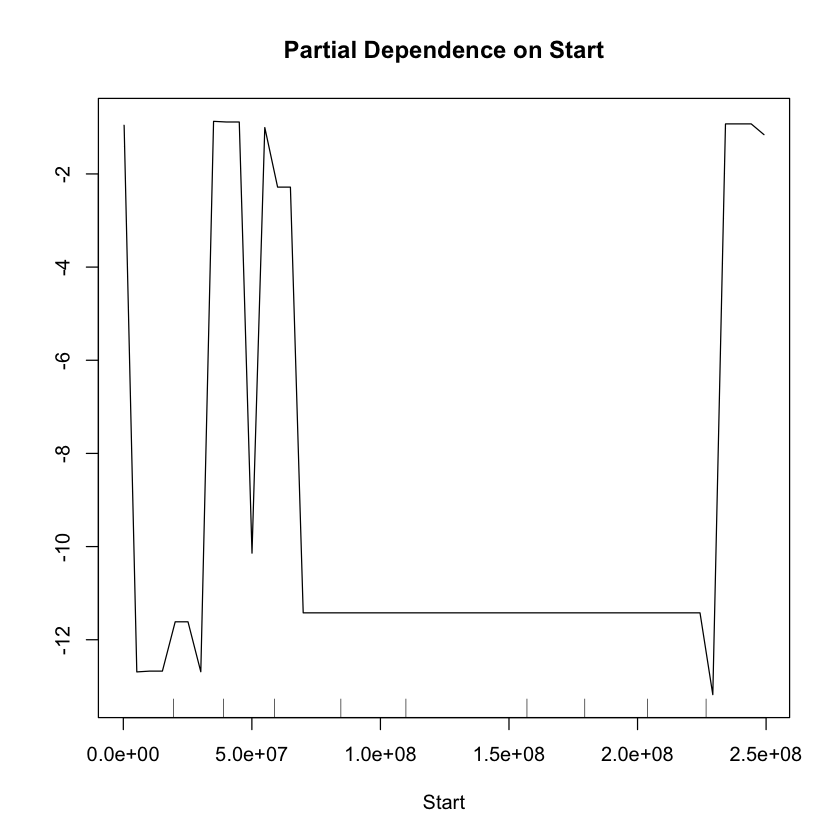

In [129]:
# Partial Dependence Plots

partialPlot(rf2, train, Start, "Enhancer")

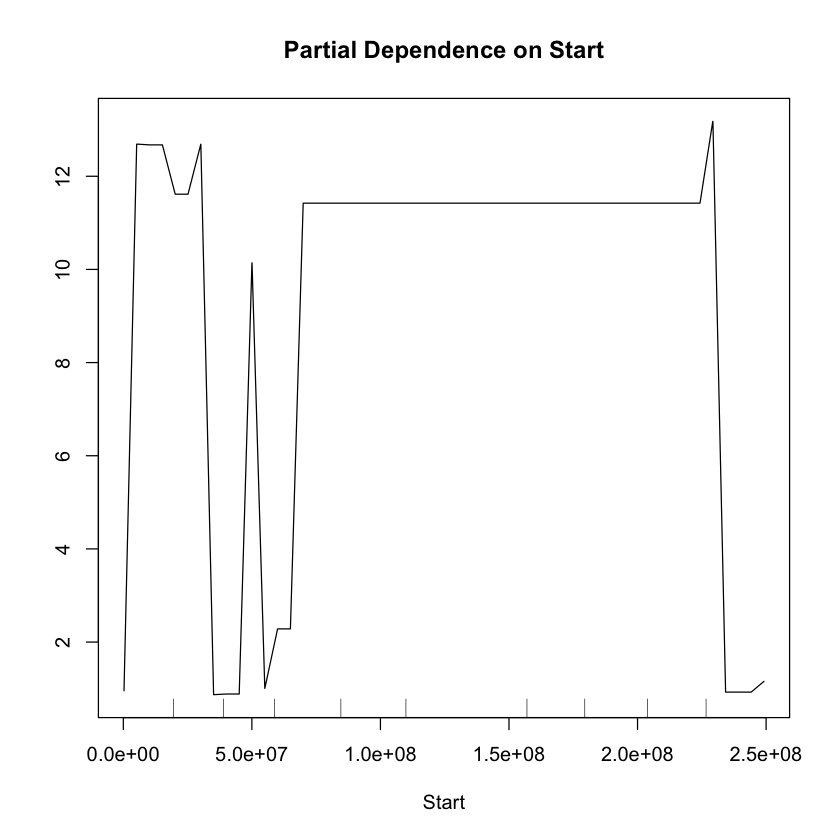

In [130]:
partialPlot(rf2, train, Start, "Non-Enhancer")

#### Exercise
- Try the partial dependence plots for "End" variable.

In [133]:
# Extract Single tree
getTree(rf2, k=1)

left daughter,right daughter,split var,split point,status,prediction
2,3,3,245931982,1,0
4,5,2,115077137,1,0
0,0,0,0,-1,2
6,7,2,56069596,1,0
0,0,0,0,-1,2
8,9,2,51715240,1,0
10,11,2,58929916,1,0
12,13,3,49784624,1,0
14,15,3,54704647,1,0
0,0,0,0,-1,2


#### Exercise
- The above example elaborates the definition for the first tree. Try different values of *k* for visualizing other trees in the forest.

Warning message in RColorBrewer::brewer.pal(nlevs, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

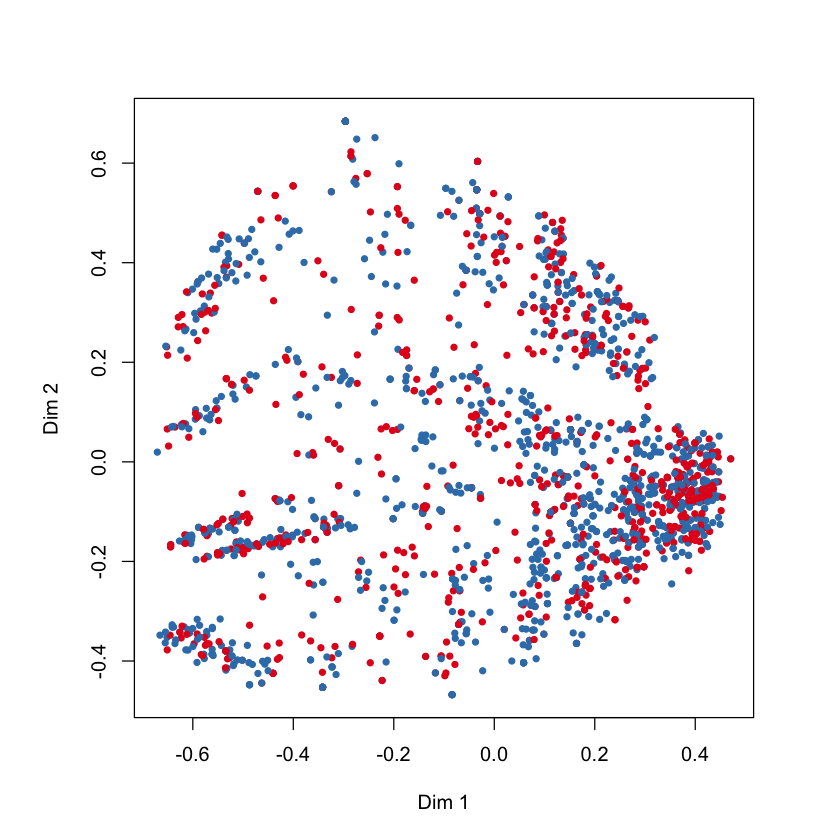

In [134]:
# Multidimensional Scaling (MDS) plot of proximity matrix.

MDSplot(rf2, train$Class)

### Notes

  1.  The authors [@Rajagopal2013] construed p300 (a transcription co-activator) binding sites overlapping DNase-I hypersentitive sites and distal to annotated transcription start sites (TSS) as active p300 binding sites representative of enhancers.
  2. Clusters with presence or absence of H3K36me3 were hypothesized to represent genic and inter-genic enhancers respectively.
  3. While pre-processing the genomic ranges data if you need to convert WIG file to BED file, you may want to refer to BEDOPS -> wig2bed() function. This is available as a command line utility.

P.S. During intermediary partitioning, if the node has the lowest Gini Index, it becomes leaf node. That will most likely be the case when all remaining non-root nodes have been exhausted, checking for impurity score.

All workshop study material is available at my github page (https://github.com/shauryajauhari).


The excercises are embedded in the body of the text itself. Please look for the same.